In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%matplotlib inline

### Load Datasets

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
stores = pd.read_csv('data/stores.csv')
oil = pd.read_csv('data/oil.csv')
holidays_events = pd.read_csv('data/holidays_events.csv')

### Data Overview

In [3]:
print("Train Data Info:")
print(train.info())
print(train.describe())

print("Test Data Info:")
print(test.info())
print(test.describe())

print("Stores Data Info:")
print(stores.info())

print("Oil Data Info:")
print(oil.info())

print("Holidays and Events Data Info:")
print(holidays_events.info())

Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None
                 id     store_nbr         sales   onpromotion
count  3.000888e+06  3.000888e+06  3.000888e+06  3.000888e+06
mean   1.500444e+06  2.750000e+01  3.577757e+02  2.602770e+00
std    8.662819e+05  1.558579e+01  1.101998e+03  1.221888e+01
min    0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00
25%    7.502218e+05  1.400000e+01  0.000000e+00  0.000000e+00
50%    1.500444e+06  2.750000e+01  1.100000e+01  0.000000e+00
75%    2.250665e+06  4.100000e+01  1.958473e+02  0.000000e+00
max    3.000887e+06  5.400000e+01  1.247170e+05  7.410000e+02
Test Data Info:
<class 'pandas.core.

In [4]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


### Data Cleaning and Preprocessing

In [5]:
def extract_datetime_features(df):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['dayOfMonth'] = df['date'].dt.day
    df['dayOfWeek'] = df['date'].dt.dayofweek
    return df

In [6]:
train=extract_datetime_features(train)
test=extract_datetime_features(test)

# Check for missing values
print("Missing values in train data:")
print(train.isnull().sum())
print("Missing values in oil data:")
print(oil.isnull().sum())

Missing values in train data:
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
year           0
month          0
dayOfMonth     0
dayOfWeek      0
dtype: int64
Missing values in oil data:
date           0
dcoilwtico    43
dtype: int64


In [7]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,year,month,dayOfMonth,dayOfWeek
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1,1
1,1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1,1
2,2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1,1
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1,1
4,4,2013-01-01,1,BOOKS,0.0,0,2013,1,1,1


## Exploratory Data Analysis

### Train Data Analysis

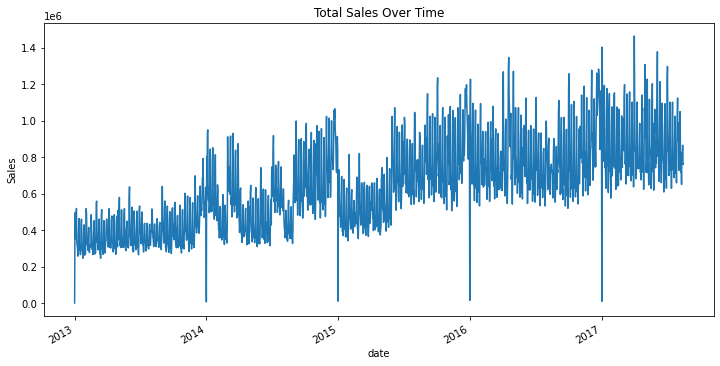

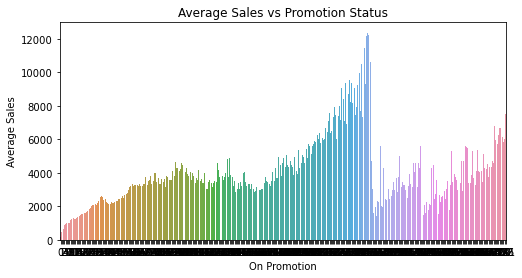

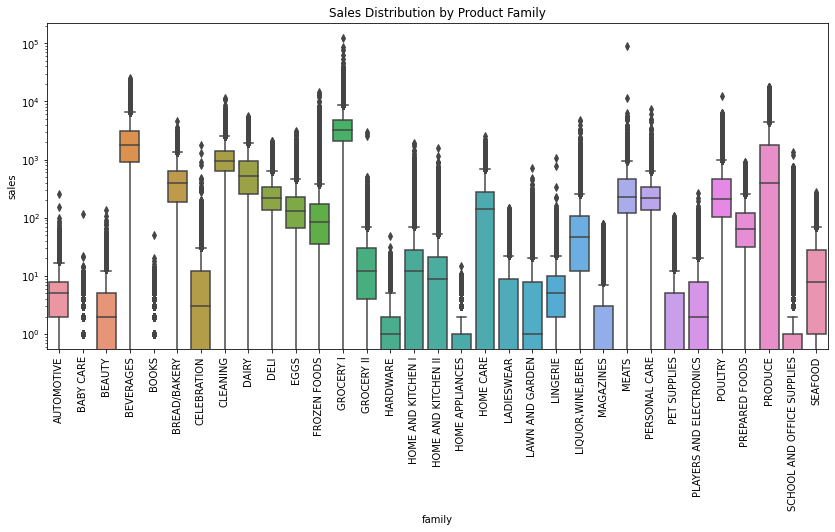

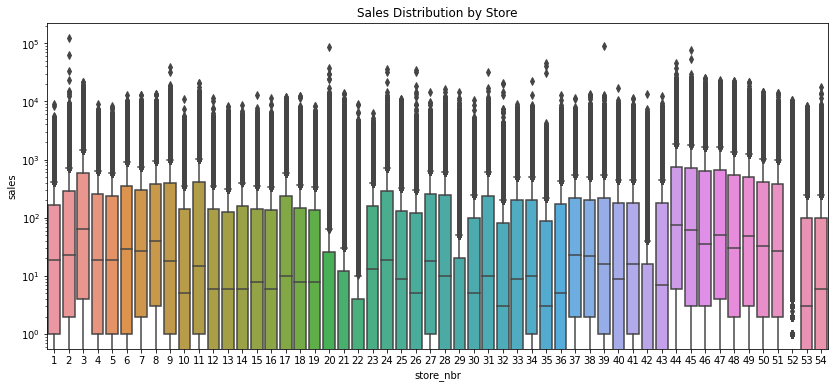

In [8]:
# Sales trend over time
plt.figure(figsize=(12,6))
train.groupby('date')['sales'].sum().plot()
plt.title('Total Sales Over Time')
plt.ylabel('Sales')
plt.show()

# Promotion impact on sales
promoted_sales = train.groupby('onpromotion')['sales'].mean()
plt.figure(figsize=(8,4))
sns.barplot(x=promoted_sales.index, y=promoted_sales.values)
plt.title('Average Sales vs Promotion Status')
plt.xlabel('On Promotion')
plt.ylabel('Average Sales')
plt.show()

# Sales by store and product family
plt.figure(figsize=(14,6))
sns.boxplot(data=train, x='family', y='sales')
plt.yscale('log')
plt.xticks(rotation=90)
plt.title('Sales Distribution by Product Family')
plt.show()

plt.figure(figsize=(14,6))
sns.boxplot(data=train, x='store_nbr', y='sales')
plt.yscale('log')
plt.title('Sales Distribution by Store')
plt.show()

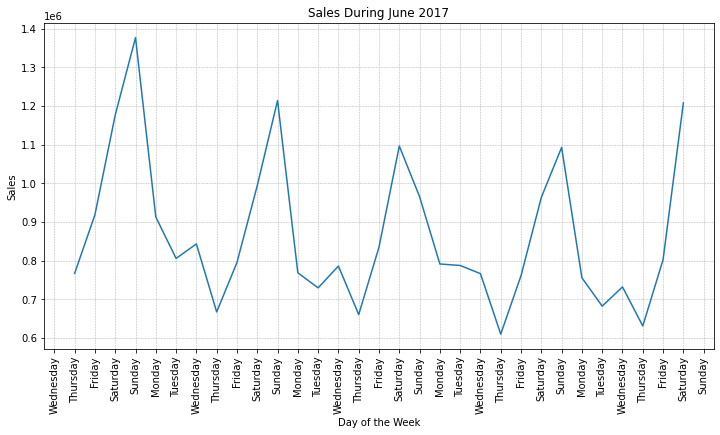

In [9]:
date = dt.datetime(2017, 6, 1)
sales = train[(train['date'] >= date) & 
              (train['date'] <= date + dt.timedelta(days=30))]

sales_by_date = sales.groupby('date')['sales'].sum()

plt.figure(figsize=(12,6))
plt.plot(sales_by_date)

plt.title('Sales During June 2017')
plt.xlabel('Day of the Week')
plt.ylabel('Sales')

plt.gca().xaxis.set_major_locator(mdates.DayLocator())  # Set ticks for every day
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%A'))  # Only show the weekday name

plt.xticks(rotation=90)
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)

plt.show()


### Weekly seasonality

/usr/local/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


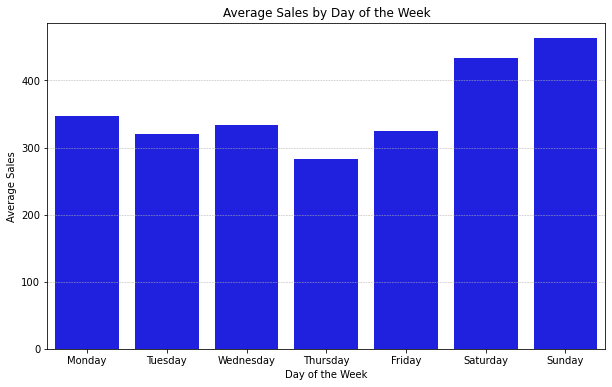

In [10]:
day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
               4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
train['dayOfWeekWord'] = train['dayOfWeek'].map(day_mapping)

# Calculate the average sales and standard deviation by day of the week
sales_by_day = train.groupby('dayOfWeekWord')['sales'].mean().reset_index()

# Ensure the order of days
sales_by_day['dayOfWeekWord'] = pd.Categorical(sales_by_day['dayOfWeekWord'], 
                                           categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
                                           ordered=True)
sales_by_day = sales_by_day.sort_values('dayOfWeekWord')

# Plot average sales by day of the week as a bar plot
plt.figure(figsize=(10,6))
sns.barplot(data=sales_by_day, x='dayOfWeekWord', y='sales', color='blue')

# Formatting
plt.title('Average Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Sales')
plt.grid(axis='y', linestyle='--', linewidth=0.5)  # Add grid only to y-axis

plt.show()


/usr/local/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


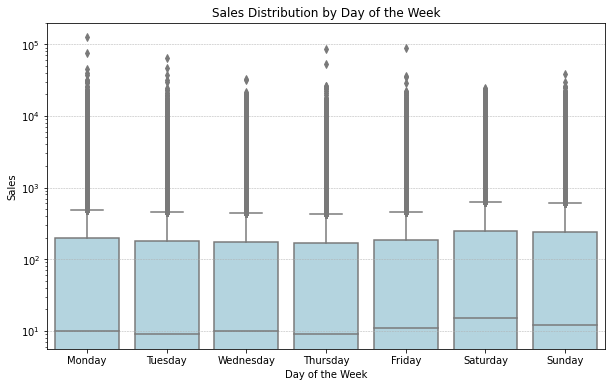

In [11]:
train['dayOfWeekWord'] = pd.Categorical(train['dayOfWeekWord'], 
                                     categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
                                                 'Friday', 'Saturday', 'Sunday'], 
                                     ordered=True)

# Plot boxplot for sales by day of the week
plt.figure(figsize=(10,6))
sns.boxplot(data=train, x='dayOfWeekWord', y='sales', color='lightblue')

# Formatting
plt.title('Sales Distribution by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Sales')
plt.grid(axis='y', linestyle='--', linewidth=0.5)  # Add grid only to y-axis
plt.yscale('log')  # Log scale for better visualization
plt.show()

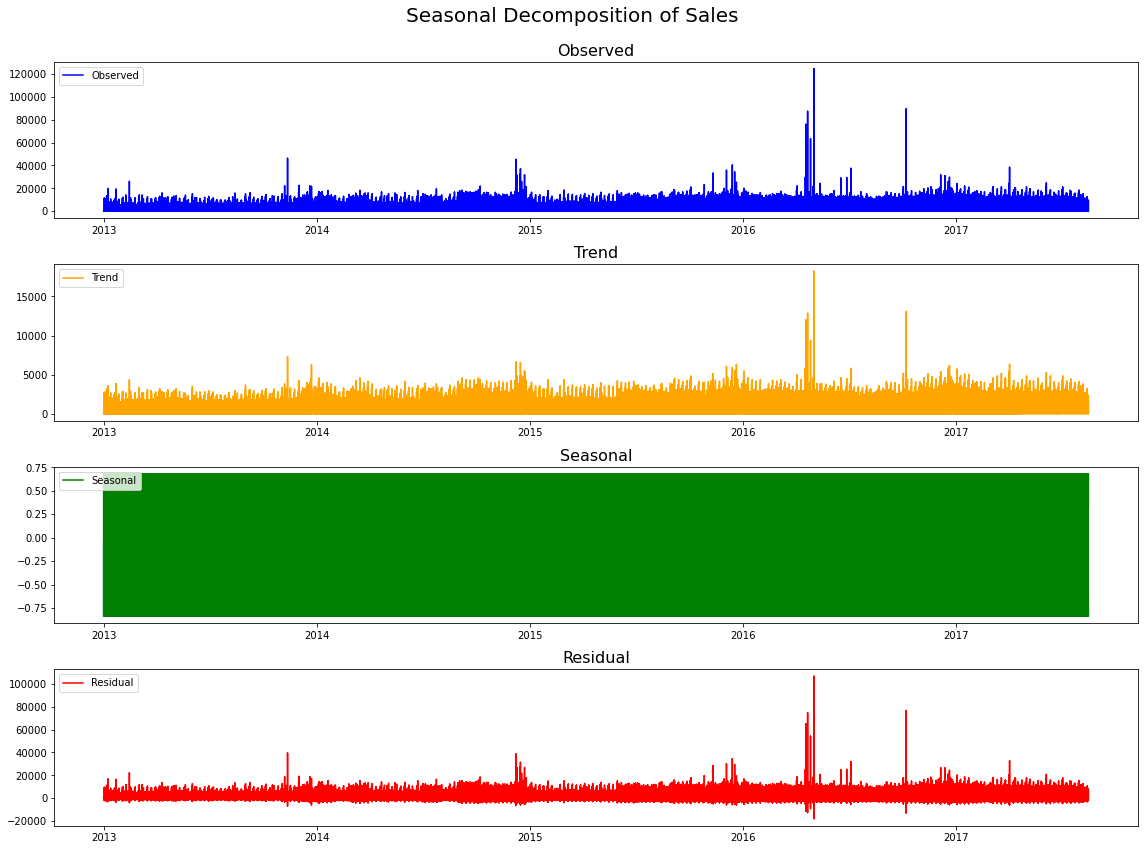

In [19]:
train.set_index('date', inplace=True)
decomposition = seasonal_decompose(train['sales'], model='additive', period=7)  # Weekly seasonality

# Create a larger figure with subplots
fig, axs = plt.subplots(4, 1, figsize=(16, 12))  # 4 rows, 1 column
fig.suptitle('Seasonal Decomposition of Sales', fontsize=20)

# Plot each component
axs[0].plot(decomposition.observed, label='Observed', color='blue')
axs[0].legend(loc='upper left')
axs[0].set_title('Observed', fontsize=16)

axs[1].plot(decomposition.trend, label='Trend', color='orange')
axs[1].legend(loc='upper left')
axs[1].set_title('Trend', fontsize=16)

axs[2].plot(decomposition.seasonal, label='Seasonal', color='green')
axs[2].legend(loc='upper left')
axs[2].set_title('Seasonal', fontsize=16)

axs[3].plot(decomposition.resid, label='Residual', color='red')
axs[3].legend(loc='upper left')
axs[3].set_title('Residual', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Make room for the main title
plt.show()


### Oil Data Analysis

<Figure size 864x432 with 0 Axes>

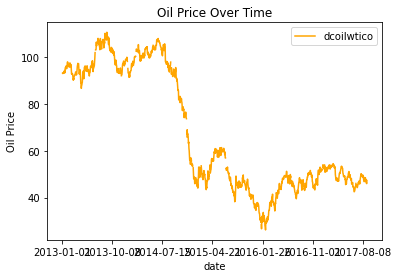

In [20]:
# Oil price trends
plt.figure(figsize=(12,6))
oil.plot(x='date', y='dcoilwtico', title='Oil Price Over Time', color='orange')
plt.ylabel('Oil Price')
plt.show()

### Holidays and Events Analysis

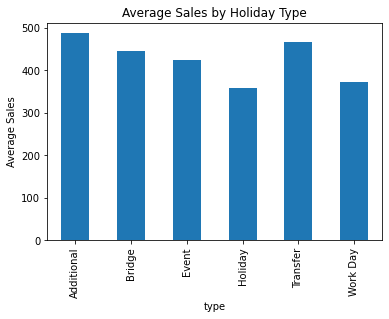

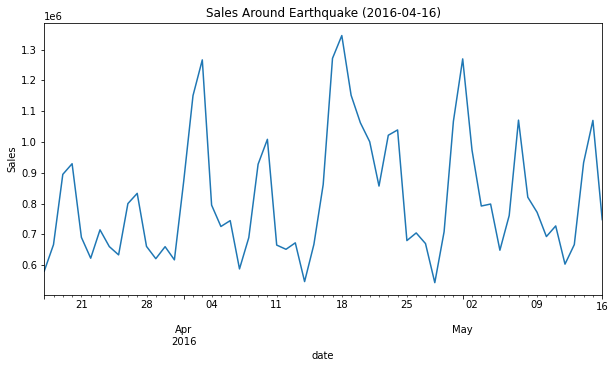

In [46]:
# Holidays impact analysis
holidays_events['date_field'] = pd.to_datetime(holidays_events.index)
holidays_sales = train.merge(holidays_events[['date_field', 'type', 'transferred']], how='left', left_on='date', right_on='date_field')
holidays_sales.groupby(['type'])['sales'].mean().plot(kind='bar')
plt.title('Average Sales by Holiday Type')
plt.ylabel('Average Sales')
plt.show()

# Check sales around earthquake date
earthquake_date = dt.datetime(2016, 4, 16)
earthquake_sales = train[(train.index >= earthquake_date - dt.timedelta(days=30)) & 
                         (train.index <= earthquake_date + dt.timedelta(days=30))]
plt.figure(figsize=(10,5))
earthquake_sales.groupby('date')['sales'].sum().plot()
plt.title('Sales Around Earthquake (2016-04-16)')
plt.ylabel('Sales')
plt.show()
